Load all the packages 

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import FITSFixedWarning
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
from astropy.stats import mad_std
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.detection import DAOStarFinder
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
import pandas as pd
from astropy.wcs import utils

Loading the 3 images of H-Alpha from the archive, stacking and averaging them, displaying it

In [3]:
# Suppress warnings
warnings.simplefilter('ignore', FITSFixedWarning)

# Load three h alpha images
image1 = CCDData.read("image1.fits", unit="adu")
image2 = CCDData.read("image2.fits", unit="adu")
image3 = CCDData.read("image3.fits", unit="adu")


# Fix FITS header issues
for img in [image1, image2, image3]:
    if 'RADECSYS' in img.header:
        img.header['RADESYSa'] = img.header.pop('RADECSYS')  # Fix RADECSYS issue
    if 'DATE-OBS' in img.header and 'MJD-OBS' not in img.header:
        img.header['MJD-OBS'] = Time(img.header['DATE-OBS'], format='isot', scale='utc').mjd  # Set MJD-OBS

# Stack images by averaging
stacked_image = (image1.data + image2.data + image3.data) / 3.0
stacked_ccd = CCDData(stacked_image, unit=image1.unit, wcs= image3.wcs)

# Save the cleaned and stacked image
stacked_ccd.write("4485stackedhalphaimage.fits", overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


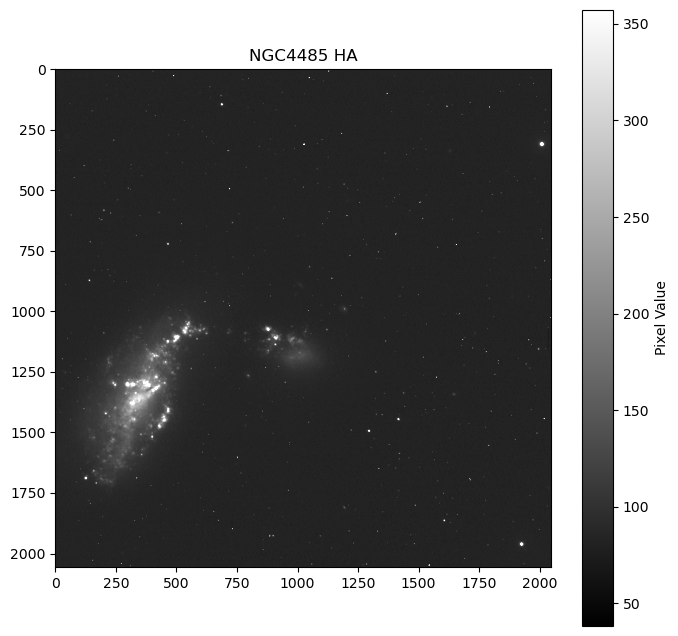

In [4]:
# Load the stacked image
stacked_ccd = CCDData.read("4485stackedhalphaimage.fits", unit="adu")

median = np.median(stacked_ccd.data)
stddv = np.std(stacked_ccd.data)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(stacked_ccd.data, vmin=median-stddv, vmax=median+(6*stddv), cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title("NGC4485 HA")
plt.show()

 Finding RA and Dec of the available stars in the image using WCS and displaying

In [102]:
# Load FITS file
fits_file = "4485stackedhalphaimage.fits"
hdul = fits.open(fits_file)
data = hdul[0].data
header = hdul[0].header

# Estimate background noise using median absolute deviation (MAD)
bkg_sigma = mad_std(data)

# Use DAOStarFinder to detect stars
daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * bkg_sigma)
sources = daofind(data)

# Fix the WCS manually if needed
wcs = WCS(header)

HAworldcoord = utils.pixel_to_skycoord(sources['xcentroid'], sources['ycentroid'], wcs) 
print (HAworldcoord)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(187.49726042, 41.78819779), (187.49726182, 41.71133972),
     (187.49774221, 41.649648  ), (187.50180186, 41.68088934),
     (187.50385165, 41.78195754), (187.5073807 , 41.77042474),
     (187.50916034, 41.6732843 ), (187.51001674, 41.66958811),
     (187.51066913, 41.63359253), (187.51331519, 41.67356082),
     (187.51359439, 41.74527656), (187.51504003, 41.76664566),
     (187.51639979, 41.64722712), (187.52755643, 41.65510229),
     (187.53214884, 41.78479056), (187.53293452, 41.68651449),
     (187.53437495, 41.74442662), (187.53457635, 41.61703347),
     (187.53480665, 41.67591454), (187.5349404 , 41.67559797),
     (187.53650226, 41.69208135), (187.53678845, 41.73776883),
     (187.5417305 , 41.62562609), (187.54261347, 41.68199099),
     (187.54344592, 41.70665657), (187.54576118, 41.75733318),
     (187.55016742, 41.70690645), (187.55065123, 41.71602083),
     (187.55255177, 41.71726417), (187.55266748, 41.67620264),
     

Performing aperture photometry to find stars and fluxes and display in HA image

      id     xcenter     ycenter  aperture_sum        HAflux         RA       DEC
0      1 2044.418298    0.458021   5300.461513   1952.160883 187.497147 41.788114
1      2 1133.556491    1.792315   8798.313413   2434.361299 187.497149 41.711255
2      3  402.441092    7.107427  12805.459807   5116.178420 187.497629 41.649564
3      4  772.742083   42.500834  12219.269156    840.471085 187.501689 41.680805
4      5 1970.550318   58.814014  12775.726638   1358.249920 187.503738 41.781873
5      6 1833.920676   90.215701  12854.898443   1480.884124 187.507267 41.770340
6      7  682.713961  107.775412  14030.576814   2737.424524 187.509047 41.673200
7      8  638.921720  115.426586  11738.070642    460.576770 187.509904 41.669504
8      9  212.339749  121.887530  12214.661415    987.022259 187.510556 41.633508
9     10  686.050438  144.549807  41330.902580  29832.200082 187.513202 41.673477
10    11 1535.972256  145.626734  11744.844352    524.078471 187.513481 41.745192
11    12 1789.24

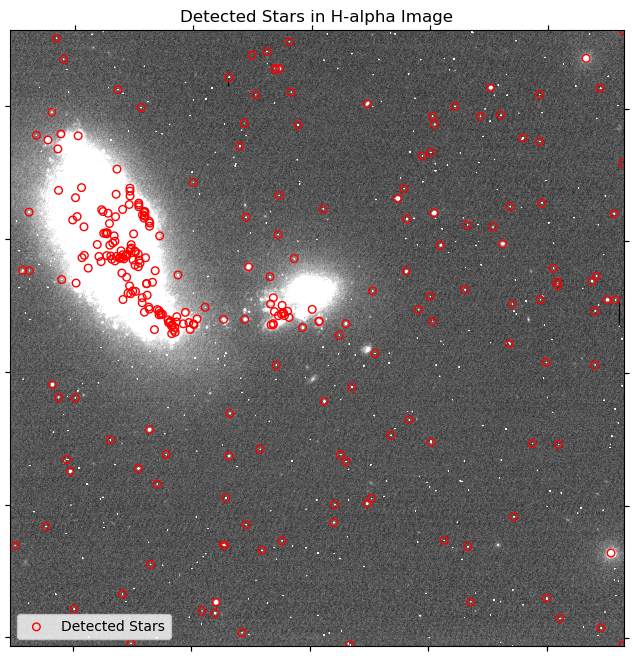

In [105]:
# File name to be used
fits_file = '4485stackedhalphaimage.fits' 

# Load FITS data (image) and header from the specified file
data, header = fits.getdata(fits_file, header=True)

# Create WCS object from the header
wcs = WCS(header)

# Assuming 'sources' is already defined and has columns 'xcentroid', 'ycentroid'
# Convert pixel positions to RA/DEC
ra, dec = wcs.all_pix2world(sources['xcentroid'], sources['ycentroid'], 1)
sources['RA'] = ra
sources['DEC'] = dec

# Create SkyCoord objects for each detected star
HAstar_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')

# Define apertures in sky coordinates
aperture_radius = 2.0 * u.arcsec  # Circular aperture (adjust as needed)
annulus_inner_radius = 3.0 * u.arcsec  # Inner annulus radius for background
annulus_outer_radius = 6.0 * u.arcsec  # Outer annulus radius for background

apertures = SkyCircularAperture(HAstar_coords, r=aperture_radius)
annuli = SkyCircularAnnulus(HAstar_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Convert to pixel-based apertures
HApixel_apertures = apertures.to_pixel(wcs)
HApixel_annuli = annuli.to_pixel(wcs)

# Perform aperture photometry
HAphot_table = aperture_photometry(data, HApixel_apertures)
HAbkg_table = aperture_photometry(data, HApixel_annuli)

# Calculate mean background per pixel inside the annulus
HAbkg_mean = HAbkg_table['aperture_sum'] / HApixel_annuli.area

# Subtract background contribution
HAphot_table['HAflux'] = HAphot_table['aperture_sum'] - (HAbkg_mean * HApixel_apertures.area)

# Add RA and DEC to photometry table
HAphot_table['RA'] = sources['RA']
HAphot_table['DEC'] = sources['DEC']

# Convert to Pandas DataFrame
df = HAphot_table.to_pandas()

# Remove rows where flux is negative
df = df[df['HAflux'] >= 0]

# Display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(df)

# Plot the image and detected stars
plt.figure(figsize=(10, 8))
plt.subplot(projection=wcs, facecolor='red')
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none', label='Detected Stars')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.legend()
plt.title('Detected Stars in H-alpha Image')
plt.show()

Removing the top left quadrant of H-Alpha and any fluxes with them

Average Flux of the retained stars (after filtering): 3110.200672
    id     xcenter     ycenter  aperture_sum       HAflux         RA       DEC
0    1 2044.418298    0.458021   5300.461513  1952.160883 187.497147 41.788114
1    2 1133.556491    1.792315   8798.313413  2434.361299 187.497149 41.711255
2    3  402.441092    7.107427  12805.459807  5116.178420 187.497629 41.649564
3    4  772.742083   42.500834  12219.269156   840.471085 187.501689 41.680805
4    5 1970.550318   58.814014  12775.726638  1358.249920 187.503738 41.781873
5    6 1833.920676   90.215701  12854.898443  1480.884124 187.507267 41.770340
6    7  682.713961  107.775412  14030.576814  2737.424524 187.509047 41.673200
7    8  638.921720  115.426586  11738.070642   460.576770 187.509904 41.669504
8    9  212.339749  121.887530  12214.661415   987.022259 187.510556 41.633508
9   10  686.050438  144.549807  41330.902580 29832.200082 187.513202 41.673477
10  11 1535.972256  145.626734  11744.844352   524.078471 187.513

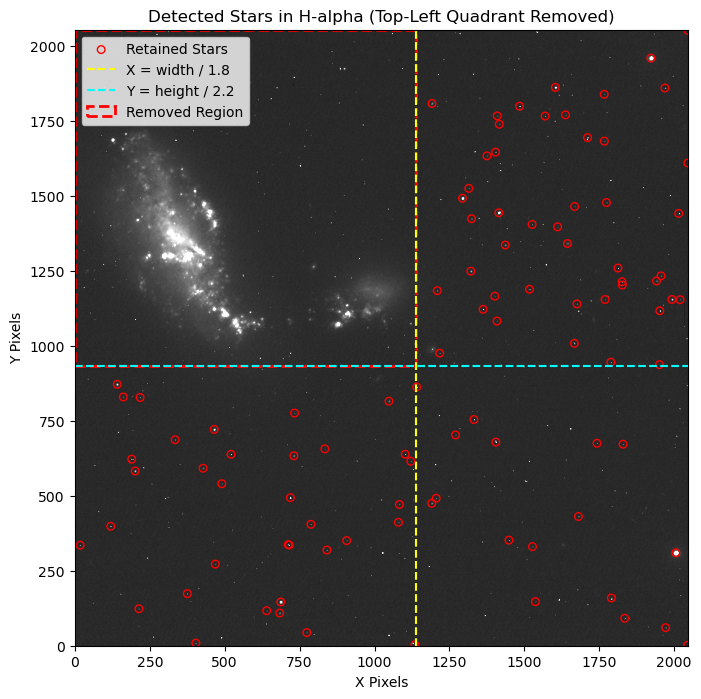

In [217]:
# File name
fits_file = '4485stackedhalphaimage.fits' 

# Load FITS data (image) and header
data, header = fits.getdata(fits_file, header=True)

# Get image dimensions
height, width = data.shape  # (Y-axis, X-axis)

# Define quadrant boundaries (Top-Left Quadrant)
x_limit = width / 1.8
y_limit = height / 2.2

# Estimate background noise
bkg_sigma = mad_std(data)

# Detect stars using DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * bkg_sigma)
sources = daofind(data)

# Convert to table
sources = Table(sources)

# Remove sources **inside** the top-left quadrant
top_left_condition = (sources['xcentroid'] <= x_limit) & (sources['ycentroid'] >= y_limit)
filtered_HAsources = sources[~top_left_condition]  # Keep only sources **outside** top-left

# Create WCS object
wcs = WCS(header)

# Convert pixel positions to RA/DEC
ra, dec = wcs.all_pix2world(filtered_HAsources['xcentroid'], filtered_HAsources['ycentroid'], 1)
filtered_HAsources['RA'] = ra
filtered_HAsources['DEC'] = dec

# Create SkyCoord objects for detected stars
HAstar_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')

# Define photometry apertures
aperture_radius = 2.0 * u.arcsec  
annulus_inner_radius = 3.0 * u.arcsec  
annulus_outer_radius = 6.0 * u.arcsec  

apertures = SkyCircularAperture(HAstar_coords, r=aperture_radius)
annuli = SkyCircularAnnulus(HAstar_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Convert to pixel-based apertures
pixel_apertures = apertures.to_pixel(wcs)
pixel_annuli = annuli.to_pixel(wcs)

# Perform aperture photometry
HAphot_table = aperture_photometry(data, pixel_apertures)
HAbkg_table = aperture_photometry(data, pixel_annuli)

# Calculate mean background per pixel inside the annulus
HAbkg_mean = HAbkg_table['aperture_sum'] / pixel_annuli.area

# Subtract background contribution
HAphot_table['HAflux'] = HAphot_table['aperture_sum'] - (HAbkg_mean * pixel_apertures.area)

# Add RA and DEC to photometry table
HAphot_table['RA'] = filtered_HAsources['RA']
HAphot_table['DEC'] = filtered_HAsources['DEC']

# Convert to Pandas DataFrame
df = HAphot_table.to_pandas()

# Remove negative flux values
df = df[df['HAflux'] >= 0]

# Filter fluxes: Keep fluxes between 100 and 100,000
df = df[(df['HAflux'] >= 100) & (df['HAflux'] <= 100000)]

# Save the filtered fluxes to a CSV file
df.to_csv("4485HAflux.csv", mode='w', index=False)

# Calculate the average flux of the filtered flux values
average_flux = df['HAflux'].mean()

# Print the average flux
print(f"Average Flux of the retained stars (after filtering): {average_flux:.6f}")

# Display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.6f}'.format)

# Print the final table (all stars EXCEPT those in top-left)
print(df)

# Plot the image and detected stars
plt.figure(figsize=(10, 8))
median = np.median(data)
stddv = np.std(data)
plt.imshow(data, cmap='gray', origin='lower', vmin=median-stddv, vmax=median+(5*stddv))

# Plot all retained detected sources (excluding top-left quadrant)
plt.scatter(filtered_HAsources['xcentroid'], filtered_HAsources['ycentroid'], s=30, edgecolor='red', facecolor='none', label='Retained Stars')

# Highlight the removed area (top-left quadrant)
plt.axvline(x_limit, color='yellow', linestyle='--', label="X = width / 1.8")
plt.axhline(y_limit, color='cyan', linestyle='--', label="Y = height / 2.2")
plt.gca().add_patch(plt.Rectangle((0, y_limit), x_limit, height - y_limit, 
                                  edgecolor='red', facecolor='none', linestyle='dashed', linewidth=2, label="Removed Region"))
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.legend()
plt.title('Detected Stars in H-alpha (Top-Left Quadrant Removed)')
plt.show()

DOING THE SAME WITH THE R-BAND IMAGE

Loading, stacking and averageing the 3 r-band images from telescope

In [114]:
# Suppress warnings
warnings.simplefilter('ignore', FITSFixedWarning)

# Load three r-band images
image1 = CCDData.read("rband1.fits", unit="adu")
image2 = CCDData.read("rband2.fits", unit="adu")
image3 = CCDData.read("rband3.fits", unit="adu")

# Fix FITS header issues
for img in [image1, image2, image3]:
    if 'RADECSYS' in img.header:
        img.header['RADESYSa'] = img.header.pop('RADECSYS') 
    if 'DATE-OBS' in img.header and 'MJD-OBS' not in img.header:
        img.header['MJD-OBS'] = Time(img.header['DATE-OBS'], format='isot', scale='utc').mjd  

# Stack images by averaging
stacked_image = (image1.data + image2.data + image3.data) / 3.0
stacked_ccd = CCDData(stacked_image, unit=image1.unit, wcs= image3.wcs)

# Save the cleaned and stacked image
stacked_ccd.write("4485stackedrbandimage.fits", overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


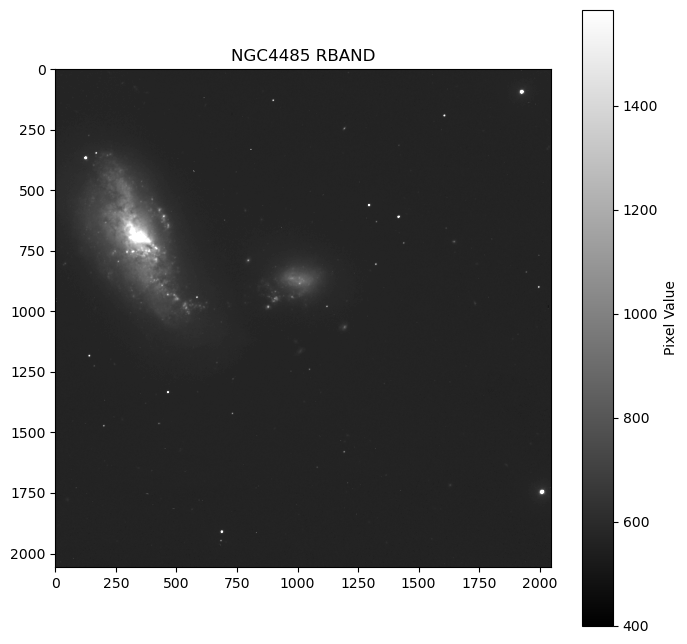

In [3]:
# Load the stacked image
stacked_ccd = CCDData.read("4485stackedrbandimage.fits", unit="adu")

# Flip the image along the x-axis (vertical flip)
flipped_data = np.flipud(stacked_ccd.data)

# Calculate statistics
median = np.median(flipped_data)
stddv = np.std(flipped_data)

# Display the flipped image
plt.figure(figsize=(8, 8))
plt.imshow(flipped_data, vmin=median-stddv, vmax=median+(6*stddv), cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title("NGC4485 RBAND")
plt.show()

 Finding RA and Dec of the available stars in the image using WCS and displaying

In [119]:
# Load FITS file
fits_file = "4485stackedrbandimage.fits"
hdul = fits.open(fits_file)
data = hdul[0].data
header = hdul[0].header

# Estimate background noise using median absolute deviation (MAD)
bkg_sigma = mad_std(data)

# Fix the WCS manually if needed
wcs = WCS(header)


Performing aperture photometry to find stars and fluxes and display in RB image

<SkyCoord (ICRS): (ra, dec) in deg
    [(187.49714709, 41.78811353), (187.49714863, 41.71125546),
     (187.49762912, 41.64956375), (187.50168871, 41.68080509),
     (187.50373832, 41.78187329), (187.50726739, 41.77034049),
     (187.50904719, 41.67320006), (187.5099036 , 41.66950387),
     (187.51055606, 41.63350829), (187.51320204, 41.67347658),
     (187.51348111, 41.74519232), (187.51492671, 41.76656142),
     (187.51628668, 41.64714288), (187.52744329, 41.65501806),
     (187.53203547, 41.78470634), (187.53282132, 41.68643027),
     (187.53426165, 41.7443424 ), (187.53446327, 41.61694925),
     (187.53469347, 41.67583032), (187.53482721, 41.67551375),
     (187.53638904, 41.69199713), (187.53667515, 41.73768462),
     (187.5416174 , 41.62554188), (187.54250027, 41.68190677),
     (187.54333267, 41.70657235), (187.54564783, 41.75724897),
     (187.55005417, 41.70682224), (187.55053795, 41.71593662),
     (187.55243849, 41.71717997), (187.55255427, 41.67611844),
     (187.55772635, 

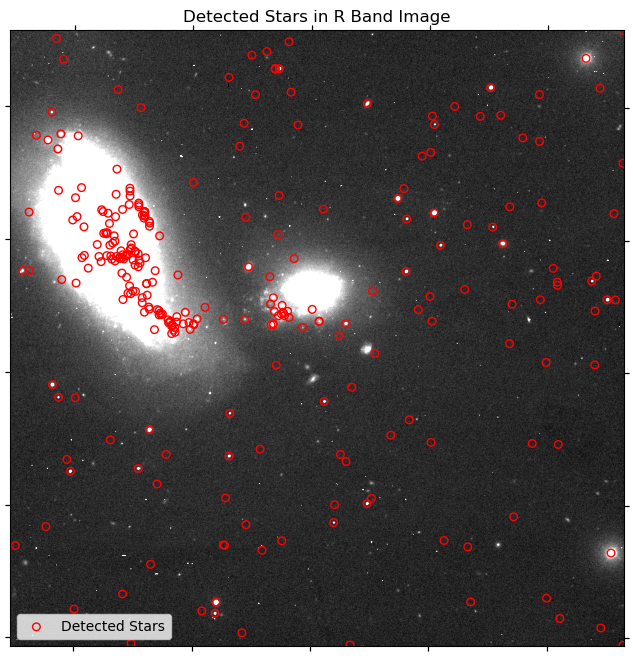

In [219]:
# File name to be used
fits_file = '4485stackedrbandimage.fits' 

# Load FITS data (image) and header from the specified file
data, header = fits.getdata(fits_file, header=True)

# Create WCS object from the header
wcs = WCS(header)



# Define apertures in sky coordinates
aperture_radius = 2.0 * u.arcsec  # Circular aperture (adjust as needed)
annulus_inner_radius = 3.0 * u.arcsec  # Inner annulus radius for background
annulus_outer_radius = 6.0 * u.arcsec  # Outer annulus radius for background

apertures = SkyCircularAperture(HAstar_coords, r=aperture_radius)
annuli = SkyCircularAnnulus(HAstar_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Convert to pixel-based apertures
RBpixel_apertures = apertures.to_pixel(wcs)
RBpixel_annuli = annuli.to_pixel(wcs)

# Perform aperture photometry
RBphot_table = aperture_photometry(data, RBpixel_apertures)
RBbkg_table = aperture_photometry(data, RBpixel_annuli)

# Calculate mean background per pixel inside the annulus
RBbkg_mean = RBbkg_table['aperture_sum'] / RBpixel_annuli.area

# Subtract background contribution
RBphot_table['RBflux'] = RBphot_table['aperture_sum'] - (RBbkg_mean * RBpixel_apertures.area)
print (HAstar_coords)
# Add RA and DEC to photometry table
RBphot_table['RA'] = HAstar_coords.ra
RBphot_table['DEC'] = HAstar_coords.dec

# Convert to Pandas DataFrame
df = RBphot_table.to_pandas()

# Save the filtered fluxes to a CSV file
df.to_csv("4485RBflux.csv", mode='w', index=False)

# Remove rows where flux is negative
df = df[df['RBflux'] >= 0]

# Display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(df)

# Plot the image and detected stars
plt.figure(figsize=(10, 8))
plt.subplot(projection=wcs, facecolor='red')
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none', label='Detected Stars')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.legend()
plt.title('Detected Stars in R Band Image')
plt.show()

Finding the ratio of fluxes and diving the r band image by this ratio

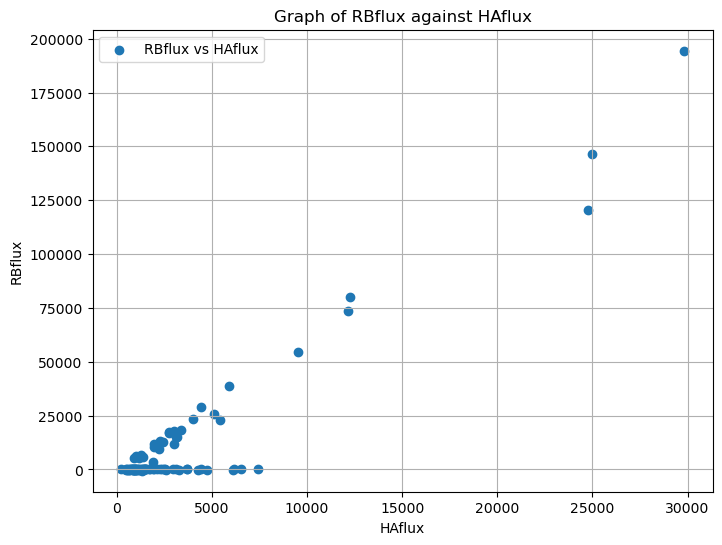

Gradient of RBflux against HAflux: 5.884932179758442


In [195]:
# Load the CSV file
df = pd.read_csv('flux.csv')

# Extract the first columns (RBflux and HAflux)
RBflux = df.iloc[:, 0]
HAflux = df.iloc[:, 1]

# Plot the graph
plt.figure(figsize=(8, 6))
plt.scatter(HAflux, RBflux, label='RBflux vs HAflux')
plt.xlabel('HAflux')
plt.ylabel('RBflux')
plt.title('Graph of RBflux against HAflux')
plt.legend()
plt.grid()
plt.show()

# Calculate the gradient (slope) using linear regression
coeffs = np.polyfit(HAflux, RBflux, 1)
gradient = coeffs[0]
print(f'Gradient of RBflux against HAflux: {gradient}')

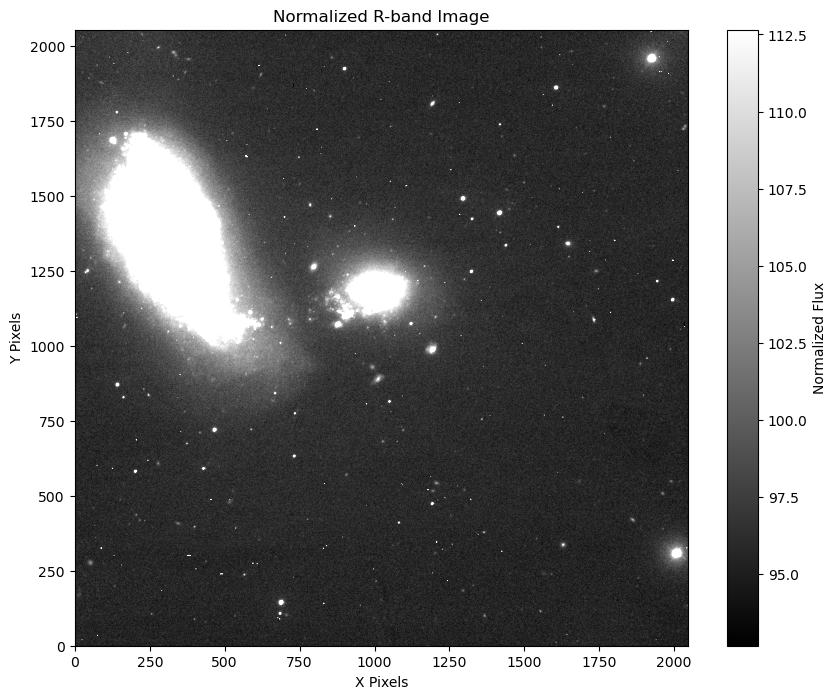

In [222]:
# File name of the R-band image 
fits_file = 'stacked_rbandimage.fits' 

# Load FITS data and header 
data, header = fits.getdata(fits_file, header=True) 

# Define the average flux ratio 
average_flux_ratio = 5.884932179758442

# Normalize the image by dividing by the average flux ratio 
normalized_data = data / average_flux_ratio 

# Save the new normalized FITS image 
normalized_fits_file = 'normalizedrband_image.fits' 
fits.writeto(normalized_fits_file, normalized_data, header, overwrite=True) 
df.to_csv("normalizedrband_image.fit", mode='w', index=False)

# Display the normalized image 
plt.figure(figsize=(10, 8)) 
plt.imshow(normalized_data, cmap='gray', origin='lower',  
           vmin=np.percentile(normalized_data, 5), vmax=np.percentile(normalized_data, 95)) 
plt.colorbar(label="Normalized Flux") 
plt.xlabel("X Pixels") 
plt.ylabel("Y Pixels") 
plt.title("Normalized R-band Image") 
plt.show() 

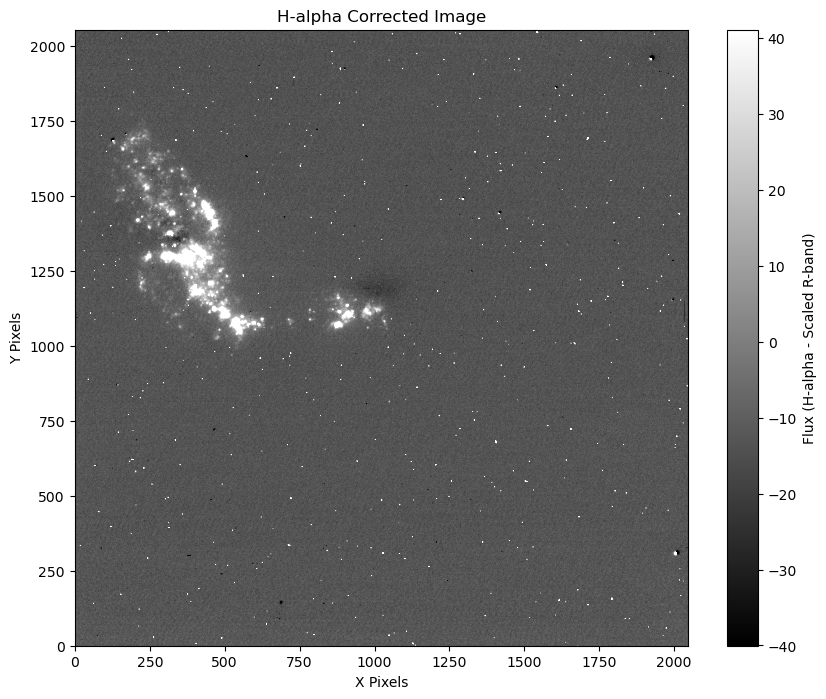

In [12]:
# File names 
halpha_fits = 'stacked_halphaimage.fits' 
normalized_rband_fits = 'normalized_rband_image.fits'  

# Load FITS data and headers 
halpha_data, halpha_header = fits.getdata(halpha_fits, header=True) 
rband_data = fits.getdata(normalized_rband_fits) 

# Subtract the scaled R-band image from the H-alpha image 
halpha_corrected = halpha_data - rband_data 

# Save the result as a new FITS file 
output_fits = 'halpha_only.fits' 
fits.writeto(output_fits, halpha_corrected, halpha_header, overwrite=True) 
  
# Calculate median and standard deviation for better scaling 
median = np.median(halpha_corrected) 
stddv = np.std(halpha_corrected) 
  
# Display the resulting image 
plt.figure(figsize=(10, 8)) 
plt.imshow(halpha_corrected, cmap='gray', origin='lower', 
           vmin=median - stddv, vmax=median + (2 * stddv)) 
plt.colorbar(label="Flux (H-alpha - Scaled R-band)") 
plt.xlabel("X Pixels") 
plt.ylabel("Y Pixels") 
plt.title("H-alpha Corrected Image") 
plt.show() 